In [2]:
%load_ext autoreload
%autoreload 2

import os
import shutil

import omegaconf
import hydra
import numpy as np
import pylab as plt
import swyft.lightning as sl
import torch
from lensx.logging_utils import log_post_plots, log_target_plots, log_train_plots
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from lensx.nn.subN.utils import print_dict

# plt.switch_backend("agg")
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
cfg = omegaconf.OmegaConf.load("config_uniform.yaml")
from lensx.nn.subN.plot import plt_imshow
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top
from tqdm.notebook import tqdm as tqdm
import matplotlib.colors


In [4]:
def check_obs(cfg):
    try:   torch.load(cfg.inference.obs_path)
    except FileNotFoundError: print('No mock generated!')
        
check_obs(cfg)

No mock generated!


In [5]:
def simulate(cfg):
    # Loading simulator (potentially bounded)
    simulator = hydra.utils.instantiate(cfg.simulation.model)

    # Generate or load training data & generate datamodule
    train_samples = sl.file_cache(
        lambda: simulator.sample(cfg.simulation.store.store_size),
        cfg.simulation.store.path,
    )[: cfg.simulation.store.train_size]
    datamodule = sl.SwyftDataModule(
        store=train_samples,
        model=simulator,  # Adds noise on the fly. `None` uses noise in store.
        batch_size=cfg.estimation.batch_size,
        num_workers=cfg.estimation.num_workers,
    )

    return datamodule, simulator
datamodule, simulator = simulate(cfg)

/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
sample = simulator.sample(1,)
sample

100%|██████████| 1/1 [00:00<00:00, 2348.43it/s]


{'img': tensor([[[-0.0320,  0.2929,  0.3189,  ...,  0.9151,  0.9580,  0.9114],
          [ 0.4617,  0.5544,  0.3050,  ...,  1.1888,  1.1104,  0.9716],
          [ 0.2807, -0.1387,  0.6022,  ...,  0.9386,  1.3572,  0.9364],
          ...,
          [ 0.7424,  1.0467,  1.5455,  ...,  0.0895,  0.2350,  0.2606],
          [ 0.8646,  1.3807,  1.2513,  ...,  0.5570,  0.1920, -0.0431],
          [ 0.8070,  1.0929,  1.0752,  ...,  0.6564,  0.0085,  0.2160]]]),
 'z_sub': tensor([[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 9.1005,  1.5485, -0.1703],
          [ 9.6058,  0.4239,  0.1665],
          [ 9.7936, -1.0195,  2.2955]]]),
 'mu': tensor([[[0.2428, 0.2545, 0.2668,  ..., 1.1371, 1.0990, 1.0609],
          [0.2546, 0.2672, 0.2804,  ..., 1.1834, 1.1413, 1.0994],
          [0.2672, 0.2806, 0.2948,  ..., 1.2304, 1.1840, 1.1382],
          ...,
          [1.1506, 1.1957, 1.2411,  ..., 0.2966, 0.2819, 0.2681],
          [1.1100, 1.1511, 1.1924,  ..., 0.2824, 0.

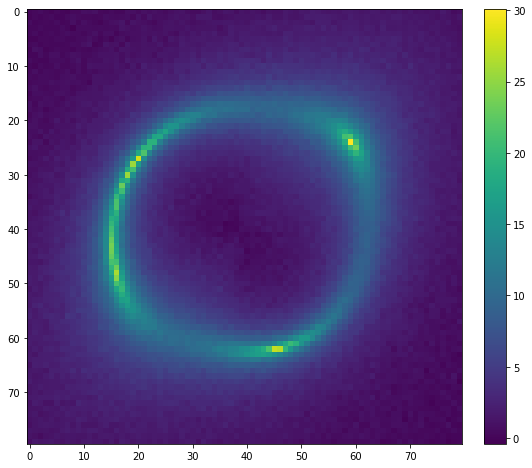

In [20]:
plt_imshow(sample['img'], cbar = True);

In [5]:
# # Setting up tensorboard logger, which defines also logdir (contains trained network)
# tbl = pl_loggers.TensorBoardLogger(
#     save_dir=cfg.tensorboard.save_dir,
#     name=cfg.tensorboard.name,
#     version=cfg.tensorboard.version,
#     default_hp_metric=False,
# )
# logdir = (
#     tbl.experiment.get_logdir()
# )  # Directory where all logging information and checkpoints etc are stored

# # Load network and train (or re-load trained network)
# network = hydra.utils.instantiate(cfg.estimation.network, cfg)
# #     network = ImgSegmNetwork(cfg, 1)

# lr_monitor = LearningRateMonitor(logging_interval="step")
# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=cfg.estimation.early_stopping.min_delta,
#     patience=cfg.estimation.early_stopping.patience,
#     verbose=False,
#     mode="min",
# )
# checkpoint_callback = ModelCheckpoint(
#     monitor="val_loss",
#     dirpath=logdir + "/checkpoint/",
#     filename="{epoch:02d}-{val_loss:.2f}",
#     save_top_k=3,
#     mode="min",
# )
# trainer = sl.SwyftTrainer(
#     accelerator=cfg.estimation.accelerator,
#     gpus=1,
#     max_epochs=cfg.estimation.max_epochs,
#     logger=tbl,
#     callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
# )
# best_checkpoint = logdir + "/checkpoint/best.ckpt"
# if not os.path.isfile(best_checkpoint):
#     trainer.fit(network, datamodule)
#     shutil.copy(checkpoint_callback.best_model_path, best_checkpoint)
#     trainer.test(network, datamodule)
# else:
#     print('realoding network?')
#     trainer.fit(network, datamodule, ckpt_path=best_checkpoint)

In [10]:
def load(cfg, simulator):
    print('Loading trained network')
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored
    
#     epoch=09-val_loss=106464.16.ckpt

    checkpoints = os.listdir( os.path.join(logdir, 'checkpoint') )
    if 'best.ckpt' in checkpoints:
        best_ckpt = 'best.ckpt'
    else:
        best_idx = np.argmax(list(map(int, [checkpoint[6:8] for checkpoint in checkpoints])))
        best_ckpt = checkpoints[best_idx]
    print(f'best checkpoint is {best_ckpt}')
    
    checkpoint = torch.load(
        os.path.join(logdir, f'checkpoint/{best_ckpt}'), map_location='cpu'
    )

    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
    network.load_state_dict(checkpoint["state_dict"])

    train_samples = torch.load(cfg.simulation.store.path)
    
    trainer = sl.SwyftTrainer(accelerator=cfg.estimation.accelerator, gpus=1)
    trainer.setup(None)
    
    datamodule = sl.SwyftDataModule(store=train_samples, model=simulator)
    datamodule.setup()
    
    trainer.model = network
    
    return network, trainer, tbl, datamodule

def analyse(cfg, datamodule):
    # Setting up tensorboard logger, which defines also logdir (contains trained network)
    tbl = pl_loggers.TensorBoardLogger(
        save_dir=cfg.tensorboard.save_dir,
        name=cfg.tensorboard.name,
        version=cfg.tensorboard.version,
        default_hp_metric=False,
    )
    logdir = (
        tbl.experiment.get_logdir()
    )  # Directory where all logging information and checkpoints etc are stored

    # Load network and train (or re-load trained network)
    network = hydra.utils.instantiate(cfg.estimation.network, cfg)
#     network = ImgSegmNetwork(cfg, 1)

    lr_monitor = LearningRateMonitor(logging_interval="step")
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=cfg.estimation.early_stopping.min_delta,
        patience=cfg.estimation.early_stopping.patience,
        verbose=False,
        mode="min",
    )
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=logdir + "/checkpoint/",
        filename="{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )
    trainer = sl.SwyftTrainer(
        accelerator=cfg.estimation.accelerator,
        gpus=1,
        max_epochs=cfg.estimation.max_epochs,
        logger=tbl,
        callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
    )
    best_checkpoint = logdir + "/checkpoint/best.ckpt"
    if not os.path.isfile(best_checkpoint):
        trainer.fit(network, datamodule)
        shutil.copy(checkpoint_callback.best_model_path, best_checkpoint)
        trainer.test(network, datamodule)
    else:
        print('realoding network?')
        trainer.fit(network, datamodule, ckpt_path=best_checkpoint)

    return network, trainer, tbl

# network, trainer, tbl = analyse(cfg, datamodule)
network, trainer, tbl, datamodule = load(cfg, simulator)

Loading trained network
best checkpoint is best.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
sample['z_sub']

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 9.1005,  1.5485, -0.1703],
         [ 9.6058,  0.4239,  0.1665],
         [ 9.7936, -1.0195,  2.2955]]])

In [15]:
network.classifier.paramtrans(sample['z_sub'].to('cuda')).cpu().shape

torch.Size([1, 3, 80, 80])

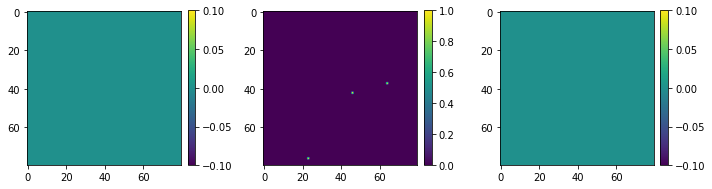

In [18]:
plt_imshow(network.classifier.paramtrans(sample['z_sub'].to('cuda')).cpu().squeeze(), cbar = True, tl = True);

# Interpret again

In [19]:
import os
import numpy as np
import pylab as plt
import torch
import swyft.lightning as sl

from lensx.nn.subN.interpret import IsotonicRegressionCalibration
from lensx.nn.subN.logging_utils_subN import LogIRC, LogPost, LogObs, LogBounds, LogSingleSub
from lensx.nn.subN.inference import Infer, Prior

In [20]:
logdir = tbl.experiment.get_logdir()

# Calculate expected n_sub
Ms = datamodule.predict_dataloader().dataset[:]['z_sub'][:,:,0]
n_sub_expect = torch.mean( torch.sum(Ms == 0, dim = 1).type(torch.float) )

# Loading the inference class and 
infer = Infer(simulator, network, datamodule, n_sub_expect)

Prior,    M_frac    in subhalo log10 mass range
1.30e-04, 3.33e-01:    [8.000 - 9.000]
1.30e-04, 3.33e-01:    [9.000 - 10.000]
1.30e-04, 3.33e-01:    [10.000 - 11.000]


In [21]:
# Prior information necessary for loggers
prior, prior_grid = infer.calc_prior()[0], infer.prior_grid()
grid_coords = infer.get_grid_coords()
grid_low, grid_high = infer.grid_low, infer.grid_high

In [10]:
# # Simulations inference
# posts_uncalib, targets = infer.get_posts(datamodule.predict_dataloader(), cfg.inference.n_infer)
# torch.save(posts_uncalib, os.path.join(logdir, 'posts_uncalib.pt'))
# torch.save(targets, os.path.join(logdir, 'targets.pt'))

# # Calibration
# irc = IsotonicRegressionCalibration(posts_uncalib, targets)    
# posts_calib = irc.calibrate(posts_uncalib)
# torch.save(posts_calib, os.path.join(logdir, 'posts_calib.pt'))

In [11]:
# Load the saved posterior and targets
posts_uncalib = torch.load(os.path.join(logdir, 'posts_uncalib.pt'))
targets       = torch.load(os.path.join(logdir, 'targets.pt'))
posts_calib = torch.load(os.path.join(logdir, 'posts_calib.pt'))

In [12]:
irc = IsotonicRegressionCalibration(posts_uncalib, targets)    

Calculating reliability curve: 100%|██████████| 626/626 [00:02<00:00, 234.87it/s]


In [13]:
# # Log simulation inference
# LogPost(tbl, posts_uncalib, targets, fig_kwargs = dict(dpi = 100, figsize = (4,3))).plot_all()
# LogPost(tbl, posts_calib,   targets, fig_kwargs = dict(dpi = 100, figsize = (4,3)), calib = 'calibrated').plot_all()
# LogIRC(tbl, irc).plot()

In [14]:
tbl.experiment.flush()
print("logdir:", logdir)

logdir: ./lightning_logs3/uniform_noise0.25_sub0-5_m8.0-11.0_pix80_msc12_sim200000/version_0


In [15]:
# assert 1 == 2

# Lavalamp plot

In [16]:
for _ in range(10000):
    test_sim = simulator.sample(1)
    if (test_sim['z_sub'][0,:,0] > 9.).sum() > 2:
        break
test_sim

100%|██████████| 1/1 [00:00<00:00, 2470.14it/s]


{'img': tensor([[[ 0.2823,  0.0208, -0.0077,  ...,  0.6381,  1.4196,  1.1114],
          [ 0.0157,  0.3091,  0.5172,  ...,  1.2298,  1.3640,  1.0909],
          [ 0.1032,  0.1189,  0.2191,  ...,  1.5323,  0.8380,  1.1733],
          ...,
          [ 1.3683,  0.7462,  0.9541,  ...,  0.1344,  0.3676,  0.2236],
          [ 1.1594,  1.7029,  1.1234,  ..., -0.0856,  0.5376,  0.3888],
          [ 1.0285,  1.3493,  1.5013,  ...,  0.4368,  0.0738, -0.4309]]]),
 'z_sub': tensor([[[ 0.0000,  0.0000,  0.0000],
          [10.7580, -1.8413,  2.4204],
          [10.4291,  0.5792,  1.1169],
          [ 8.2942,  1.3329,  1.7621],
          [10.8436, -1.2217, -0.5941]]]),
 'mu': tensor([[[0.2617, 0.2746, 0.2881,  ..., 1.1942, 1.1536, 1.1129],
          [0.2750, 0.2888, 0.3034,  ..., 1.2444, 1.1994, 1.1547],
          [0.2890, 0.3039, 0.3196,  ..., 1.2955, 1.2459, 1.1968],
          ...,
          [1.2239, 1.2702, 1.3163,  ..., 0.3187, 0.3024, 0.2871],
          [1.1815, 1.2242, 1.2668,  ..., 0.3032, 0.

In [17]:
test_post_uncalib = infer.get_post(test_sim).squeeze(0)
test_sim = infer.squeeze_obs(test_sim)
test_post = irc.calibrate(test_post_uncalib)

In [18]:
# logobs = LogObs(None, test_sim, test_post, prior, grid_coords)

# for zlog in [False, True]:
#     logobs.plot_msc(zlog = zlog, 
#                     plot_true = True,
#                     title = rf'Sum posterios $= {torch.sum(test_post).item():.2f}$',
#                     vminmax = True,
#                    );

In [19]:
# 
# m_centers, m_edges, xy_centers, xy_edges = grid_coords
# X, Y, Z = torch.meshgrid(xy_centers, xy_centers, m_centers)
# values = np.transpose(post, [2, 1, 0])

# z_sub = obs['z_sub'].numpy()
# z_sub = z_sub[np.sum(np.abs(z_sub), axis = 1) != 0] 
# M_sub, x_sub, y_sub = z_sub.T

# # values = values[:20, :20, :6]

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [21]:
def colormap(x):
    cmap = matplotlib.cm.get_cmap('viridis')(x)
    return [x, f'rgb{cmap[:-1]}']

norm = matplotlib.colors.Normalize()
colorscale = [colormap(i) for i in np.linspace(0, 1, 10)]

In [22]:
def lavalamp(post, obs, grid_coords):
    m_centers, m_edges, xy_centers, xy_edges = grid_coords
    X, Y, Z = torch.meshgrid(xy_centers, xy_centers, m_centers)
    values = np.transpose(post, [2, 1, 0])
    
    z_sub = obs['z_sub'].numpy()
    z_sub = z_sub[np.sum(np.abs(z_sub), axis = 1) != 0] 
    M_sub, x_sub, y_sub = z_sub.T
    
    im = np.array(obs['img'])
    im_x, im_y = im.shape
    x = np.linspace(grid_low[1], grid_high[1], im_x)
    y = np.linspace(grid_low[2], grid_high[2], im_y)
    z = np.ones(im.shape) * grid_low[0]
    
    

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=['Normal scale', 'Logarithmic scale'],
                        )

    for ncol, v, cbar_x in zip([1, 2], [values, np.log10(values)], [-0.10, None]):
        fig.add_trace(go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=v.flatten(),
            surface_count = 20,
        #     opacity = 0.1,
            opacityscale = [[0, 0], [1, 0.9]],
            colorbar_x=cbar_x,
        ), 1, ncol)

        fig.add_trace(go.Scatter3d(
            x = x_sub,
            y = y_sub,
            z = M_sub,
            mode ='markers',
            marker = dict(
                color = 'red',
                symbol = 'x',
                size = 5,
            ),
        ), 1, ncol)

    fig.add_trace(go.Surface(x=x, y=y, z=z,
        surfacecolor=im, 
        colorscale=colorscale,
        showscale=False,
    #     lighting_diffuse=1,
    #     lighting_ambient=1,
    #     lighting_fresnel=1,
    #     lighting_roughness=1,
    #     lighting_specular=0.5,
    ), 1, 1)


    fig.update_layout(
        height = 800, 
        width = 1600, 
        title_text="Subhalo posteriors",
        scene = dict(
            xaxis=dict(title=r"x"),
            yaxis=dict(title=r"y"),
            zaxis=dict(title=r'M'),
        ),
        showlegend=False
    )
    
    return fig
    


# version = 1
# post, obs = test_post.cpu().numpy(), test_sim
# fig = lavalamp(post, obs, grid_coords)
# fig.show()
# fig.write_html(f"lavalamp_v{version}.html")

# Logarithmic relicurve

In [23]:
assert 1 == 2

AssertionError: 

In [126]:
DEVICE = 'cuda'

class Alpha():
    def __init__(self, posts, n_alpha = 50):
        self.n_alpha = n_alpha
        self.alpha_edges = torch.linspace(0, 1, n_alpha, device = DEVICE)#, dtype=torch.float64)
        self.alpha_centers = (self.alpha_edges[:-1] + self.alpha_edges[1:])/2
        
class LogAlpha():
    def __init__(self, posts, n_alpha = 50):
        self.n_alpha = n_alpha
        
        posts_min = torch.log10(posts.min())
        posts_max = torch.log10(posts.max())
        self.alpha_edges = torch.logspace(posts_min, posts_max, self.n_alpha, device = DEVICE)
        
        self.alpha_edges = torch.cat((
#             torch.tensor([0.], device = DEVICE),
            self.alpha_edges,
#             torch.tensor([1], device = DEVICE)
        ))
        
        self.n_alpha = len(self.alpha_edges)

        self.alpha_centers = (self.alpha_edges[:-1] + self.alpha_edges[1:])/2
        

class PostData(LogAlpha):
    def __init__(self, posts, targets, n_alpha = 50):
        super().__init__(posts = posts, n_alpha = n_alpha)
        self.posts = posts
        self.targets = targets
        
    def get_histogram(self):
        hist = torch.histogram(self.posts.flatten().cpu(), bins = self.alpha_edges.cpu())[0].to(DEVICE)
        return hist
    
    def get_relicurve(self, batch_size = 16):
        
        is_between_sum = torch.zeros_like(self.alpha_centers)
        
        for batch_idx in tqdm(range(int(np.ceil(len(self.posts) / batch_size))), desc='Calculating reliability curve'):
            i, j = batch_idx*batch_size, (batch_idx+1)*batch_size
            posts_alpha = torch.repeat_interleave(self.posts[i:j].unsqueeze(-1), self.n_alpha-1, dim = -1)
            targets_alpha = torch.repeat_interleave(self.targets[i:j].unsqueeze(-1), self.n_alpha-1, dim = -1)
        
            is_between = (posts_alpha > self.alpha_edges[:-1]) & (posts_alpha < self.alpha_edges[1:])
            is_between_sum += torch.sum(targets_alpha * is_between, dim = (0, 1, 2, 3))
        hist = self.get_histogram() 
        relicurve = is_between_sum/hist
        relicurve = torch.nan_to_num(relicurve)
        return relicurve, is_between_sum

In [127]:
postdata = PostData(posts_uncalib, targets)

In [129]:
relicurve, is_between_sum = postdata.get_relicurve()

Calculating reliability curve:   0%|          | 0/626 [00:00<?, ?it/s]

In [133]:
hist

tensor([1.7000e+01, 2.5000e+01, 8.3000e+01, 2.7500e+02, 5.3300e+02, 1.1690e+03,
        2.3260e+03, 4.2340e+03, 7.2000e+03, 1.1821e+04, 1.9595e+04, 3.2055e+04,
        5.3819e+04, 9.1005e+04, 1.5644e+05, 2.6535e+05, 4.3378e+05, 6.8932e+05,
        1.0541e+06, 1.5429e+06, 2.1657e+06, 2.9196e+06, 3.8205e+06, 4.8844e+06,
        6.1661e+06, 7.6014e+06, 9.1766e+06, 1.1029e+07, 1.3185e+07, 1.5547e+07,
        1.8028e+07, 2.0177e+07, 2.1790e+07, 2.3826e+07, 2.6616e+07, 3.0161e+07,
        3.3768e+07, 3.7892e+07, 4.1692e+07, 4.6156e+07, 5.0428e+07, 6.3448e+07,
        1.0066e+08, 1.0066e+08, 1.4317e+07, 2.3899e+06, 5.7757e+05, 1.3185e+05,
        1.5479e+04], device='cuda:0')

In [132]:
is_between_sum

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 5.4000e+01,
        1.1200e+03, 6.1640e+03, 3.4690e+03, 3.8620e+03, 5.1970e+03, 4.5080e+03,
        4.9000e+02], device='cuda:0')

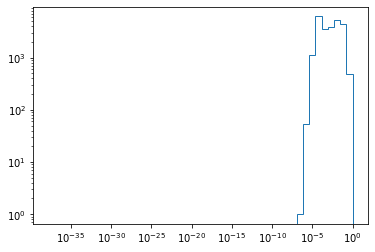

In [131]:
plt.stairs(is_between_sum.cpu(), postdata.alpha_edges.cpu())
# plt.plot((posts_min, posts_max ), (posts_min, posts_max ), 'k:')
plt.xscale('log')
plt.yscale('log')

In [122]:
posts_min, posts_max = postdata.posts.min().cpu(), postdata.posts.max().cpu()

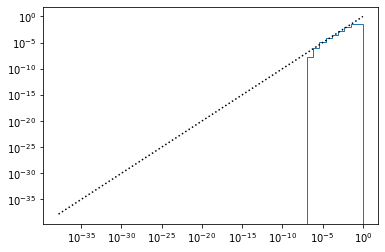

In [123]:
plt.stairs(relicurve.cpu(), postdata.alpha_edges.cpu())
plt.plot((posts_min, posts_max ), (posts_min, posts_max ), 'k:')
plt.xscale('log')
plt.yscale('log')

In [106]:
a   = torch.tensor([1e-10])
eps = torch.tensor([1e-17])

a + eps == a

tensor([False])

smallest posterior = 1.5385224381318284e-38, largest posterior = 0.9820960164070129


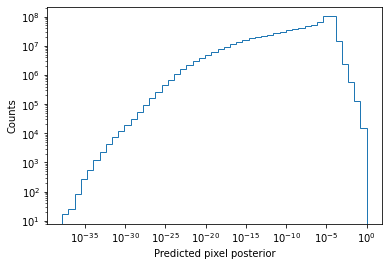

>>> torch.finfo(torch.float32)
finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, tiny=1.17549e-38, dtype=float32)


In [116]:
print(f'smallest posterior = {posts_uncalib.min()}, largest posterior = {posts_uncalib.max()}')


plt.stairs(hist.cpu(), postdata.alpha_edges.cpu())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted pixel posterior')
plt.ylabel('Counts')
plt.show()

print('>>> torch.finfo(torch.float32)', torch.finfo(torch.float32), sep = '\n')
